In [4]:
"""
Common Libraries Used in the Cells below 
"""
import sys as sys
import os as os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv
import numpy as np
from matplotlib.ticker import LogLocator, FormatStrFormatter , NullFormatter

<h1> Understanding the Default App Updates WorkFlow (Please Ignore this, I was doing this for testing implementation) </h1> 
The following code section will show us the idea of how the default application's workflow will be changed as we increase the server counter which is basically the number of requests by the Client 
<br>
Everytime the client sends the message , self.counter will increase


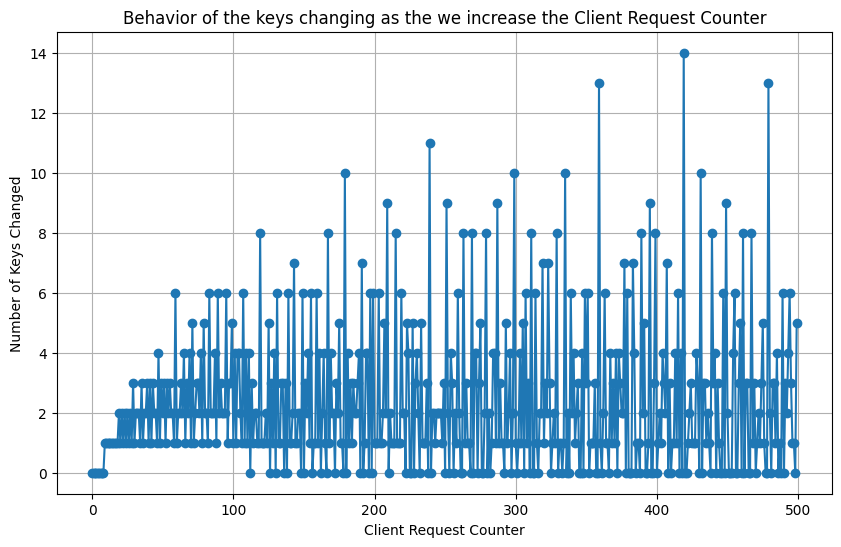

In [3]:
# Assuming your notebook is in the root directory, adjust the path accordingly
# The function below is just copied from common/keySaver.py


def isUpdateRequired(keyIndex , totalKeys = None):

        if ((counter % (keyIndex+5)) == 0):
            return True

counter = 1
dynamicVariables = 100
num_runs = 500
true_counts = [0] * num_runs

# Iterate over the key indices
for clientCounter in range(0 , num_runs):
 
    # Run the function to get the total states expected to be changed 
    for keyIndex in range(0 , dynamicVariables):
        if isUpdateRequired(keyIndex+5):
            true_counts[clientCounter] += 1
    
    counter += 1

## Now we plot the graphs :
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(0,num_runs), true_counts, marker='o')
plt.xlabel('Client Request Counter')
plt.ylabel('Number of Keys Changed')
plt.title('Behavior of the keys changing as the we increase the Client Request Counter')
plt.grid(True)
plt.show()




# Pre-processing the Data from Simulation

Most of the data is in the <span style="color: yellow">right format</span>. We will be working on the following tasks:

1. Adding relevant headers to CSV files.
2. Adding ensuring correct format in all of the `.events` file
3. These functions are designed in a way that you can run them again just to ensure `.csv` files are in the correct format for our experiments


In [5]:
def count_files(directory , fileType : str):
    rtt_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if fileType in file and file.endswith(".csv"):
                rtt_count += 1
    return rtt_count


def add_header_to_csv(file_path, header):
    with open(file_path, 'r+', newline='') as file:
        lines = file.readlines()
        if lines and lines[0].strip() != header:
            file.seek(0, 0)  
            file.write(header + '\n' + ''.join(lines))
            # print(f"Header added to {file_path}")
        

def add_header_and_adjust_counters(file_path, header):
    temp_file_path = file_path + '.tmp'
    
    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        lines = list(reader)
        
        # checkin if header is present
        if lines and lines[0] != header.split(','):
            # Add the header
            lines.insert(0, header.split(','))
        
        # check the counter value in the first line (after header is added)
        should_adjust = True
        if len(lines) > 1 and len(lines[1]) >= 2 and lines[1][1].isdigit():
            if int(lines[1][1]) == 1:
                should_adjust = False
        
        # Decrease the counter number of each entry by 1 if applicable
        if should_adjust:
            for row in lines[1:]:  # Skip header row
                if len(row) >= 2 and row[1].isdigit():
                    row[1] = str(int(row[1]) - 1)
    
    # write the changes to a temporary file and then replace the original file
    with open(temp_file_path, 'w', newline='') as temp_file:
        writer = csv.writer(temp_file)
        writer.writerows(lines)
    
    os.replace(temp_file_path, file_path)
    # print(f"Header added and counters adjusted in {file_path}")



def process_rtt_files(directory):
    header = "Event_Type,Counter,Response_Time"
    for root, dirs, files in os.walk(directory):
        for file in files:
            if "RTT" in file and file.endswith(".csv"):
                file_path = os.path.join(root, file)
                add_header_and_adjust_counters(file_path, header)


def process_events_files(directory):
    header = "Event_Type,Keys_Migrated,Key_Size,Migration_Time"
    for root, dirs, files in os.walk(directory):
        for file in files:
            if "Events" in file and file.endswith(".csv"):
                file_path = os.path.join(root, file)
                add_header_to_csv(file_path,header)






# Specify the directory path
directory_path = 'results_fig_11_fig_12/'


"""
    Step 1 : Adjusting the Header & Counters of the RTT Files :
"""
total_rtt_files = count_files(directory_path,"RTT")
print(f"Total number of RTT CSV files: {total_rtt_files}")
# Process RTT files
process_rtt_files(directory_path)
print(f"The RTT files have been successfully processed")


"""
    Step 2 : Adjusting the Header for the Event files :
"""
total_rtt_files = count_files(directory_path,"Events")
print(f"Total number of Events CSV files: {total_rtt_files}")
process_events_files(directory_path)
print(f"The Events files have been successfully processed")




Total number of RTT CSV files: 37
The RTT files have been successfully processed
Total number of Events CSV files: 37
The Events files have been successfully processed


## General Info about our Files :
- Well if you see, all of the files have their names in unique format that speicify the properties of the experiment data they contain.
- Basically all experiments are set up using the configuration file in `configuration/config.json`
- Below functions and the python file in the keySaver.py specify the exact format .
- For how the experiments are conducted ,please see the `/startEvaluation.py`

In [204]:
def parseFileName(filename):
    """
    Parse the filename to extract the configuration parameters and return a dictionary.
    """
    # Remove folder path if present
    filename = os.path.basename(filename)
    
    # Determine file type and remove the extension
    file_type = None
    if filename.endswith("RTT-microsec.csv"):
        filename = filename.replace("RTT-microsec.csv", "")
        file_type = "RTT-microsec"
    elif filename.endswith("Events.csv"):
        filename = filename.replace("Events.csv", "")
        file_type = "Events"
    
    # Remove trailing underscore
    if filename.endswith("_"):
        filename = filename[:-1]

    parts = filename.split('_')
    
    keys = [
        'asyncType', 'clientRequestRate', 'handoverTime', 'hintTime', 
        'minOldestUpdates', 'maxOldestUpdates', 'totalVariables', 
        'dynamicVariables', 'keySize'
    ]

    if len(parts) != len(keys):
        raise ValueError(f"Filename format does not match the expected format.{len(parts)} : {len(keys)}")
    
    parsed_data = dict(zip(keys, parts))
    parsed_data['fileType'] = file_type
    return parsed_data




def get_filenames_by_properties(directory_path, properties):
    """
    Return a list of filenames that satisfy the given properties.
    """
    matching_filenames = []
    
    for root, _, files in os.walk(directory_path):

        for file in files:
            if file.endswith(".csv"):
                try:
                    parsed_data = parseFileName(file)
                    matches = True
                    
                    # Debugging information
                    # print(f"Checking file: {file}")
                    for key, value in properties.items():
                        parsed_value = parsed_data.get(key)
                        if str(parsed_value) != str(value):
                            # print(f"  Property mismatch: {key} (parsed: {parsed_value}, expected: {value})")
                            matches = False
                            break
                        # else:
                        #     # print(f"  Property match: {key} (value: {parsed_value})")
                    
                    if matches:
                        # print(f"Adding file : {file}")
                        matching_filenames.append(os.path.join(root, file))
                        # print("Matching File is : ",matching_filenames)
                except ValueError as e:
                    print(f"Skipping file {file}: {e}")
                    
    return matching_filenames




def calculate_hint_statistics(filename):
    """
    Calculate statistics for 'Hint' events in the given RTT-microsec.csv file.
    
    Parameters:
    filename (str): The path to the RTT-microsec.csv file.
    
    Returns:
    dict: A dictionary with mean, median, quartiles, and response times for 'Hint' events.
    """
    response_times = []
    
    with open(filename, mode='r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            if row['Event_Type'] == 'Hint':
                response_times.append(float(row['Response_Time']))
    
    if not response_times:
        return {
            'mean': 0.0,
            'median': 0.0,
            'q1': 0.0,
            'q3': 0.0,
            'response_times': []
        }
    
    response_times = np.array(response_times)
    mean = np.mean(response_times)
    median = np.median(response_times)
    q1 = np.percentile(response_times, 25)
    q3 = np.percentile(response_times, 75)
    
    return {
        'mean': mean,
        'median': median,
        'q1': q1,
        'q3': q3,
        'response_times': response_times
    }


def plot_box_whisker_combined(data1, data2, title, xAxisList , x_label , y_label , legendLabel):
    """
    Plot a combined box-and-whisker plot for the given data.
    
    Parameters:
    data1 (list): A list of lists containing response times for the first dataset.
    data2 (list): A list of lists containing response times for the second dataset.
    title (str): The title of the plot.
    """
    plt.rcdefaults()
    plt.figure(figsize=(14, 8))

    # Combine data for side-by-side plotting
    data_combined = []
    positions = []
    outer_gap = 0.9  # Space between pairs
    inner_gap = 0.3  # Space between boxes of the same pair

    for i in range(len(data1)):
        data_combined.append(data1[i])
        data_combined.append(data2[i])
        positions.append(i * outer_gap)
        positions.append(i * outer_gap + inner_gap)

    # Plot data with different colors for each dataset
    plt.boxplot(data_combined[::2], positions=[p for p in positions[::2]], widths=0.2, patch_artist=True,
                boxprops=dict(facecolor='red'),
                medianprops=dict(color='yellow'),
                whiskerprops=dict(color='red'),
                capprops=dict(color='red'),
                showfliers=False)
    plt.boxplot(data_combined[1::2], positions=[p for p in positions[1::2]], widths=0.2, patch_artist=True,
                boxprops=dict(facecolor='orange'),
                medianprops=dict(color='yellow'),
                whiskerprops=dict(color='orange'),
                capprops=dict(color='orange'),
                showfliers=False)
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    color_box1 = mpatches.Patch(color='red', label=legendLabel[0], linewidth=0.5, alpha=0.2)
    color_box2 = mpatches.Patch(color='orange', label=legendLabel[1], linewidth=0.5, alpha=0.2)
    plt.xticks(ticks=[i * outer_gap + inner_gap / 2 for i in range(len(data1))], labels=[str(oldRange) for oldRange in (xAxisList)])
    plt.legend(handles = [color_box1 , color_box2], loc="upper right")
    plt.grid(True)
    plt.show()


## Replicating the Paper related style for the graphs 
def plot_box_whisker_combined_2(data1, data2, title, xAxisList , x_label , y_label , legendLabel, annotated = False , logYaxis = False , ExactPositions = None , legendPosition = "upper right",name ="figure_11.png"):
    """
    Plot a combined box-and-whisker plot for the given data.
    
    Parameters:
    data1 (list): A list of lists containing response times for the first dataset.
    data2 (list): A list of lists containing response times for the second dataset.
    title (str): The title of the plot.
    """
    
    plt.rcParams['font.family'] = 'Arial'
    if logYaxis == False :
        plt.figure(figsize=(5.4, 2.5) , constrained_layout=True)
    else :
        plt.figure(figsize=(5.4, 2.2) , constrained_layout=True)
    plt.grid(visible=True, which='both', color='#999999', linestyle='-', alpha=0.2)

    # Combine data for side-by-side plotting
    data_combined = []
    positions = []
    
    outer_gap = 0.9  # Space between pairs
    inner_gap = 0.3  # Space between boxes of the same pair
    

    for i in range(len(data1)):
        data_combined.append(data1[i])
        data_combined.append(data2[i])
        positions.append(i * outer_gap)
        positions.append(i * outer_gap + inner_gap)

    # Plot data with different colors for each dataset
    plt.boxplot(data_combined[::2], positions=[p for p in positions[::2]], widths=0.2, patch_artist=True, 
                boxprops=dict(facecolor='none', edgecolor='blue', hatch='////' , linewidth=0.5 ),
                medianprops=dict(color='blue' ,  linewidth=1.0),
                whiskerprops=dict(color='blue' ,  linewidth=0.5),
                capprops=dict(color='blue' ,  linewidth=0.5),
                showfliers=False)
    plt.boxplot(data_combined[1::2], positions=[p for p in positions[1::2]], widths=0.2, patch_artist=True,
                boxprops=dict(facecolor='none', edgecolor='red', hatch='////' , linewidth=0.5),
                medianprops=dict(color='red' ,  linewidth=1.0),
                whiskerprops=dict(color='red' , linewidth=0.5),
                capprops=dict(color='red' ,  linewidth=0.5),
                showfliers=False)
    
    plt.title(title)
    plt.xlabel(x_label,fontsize = 14)
    plt.ylabel(y_label ,fontsize = 14)

    

    color_box1 = mpatches.Patch(edgecolor='blue', label=legendLabel[0], linewidth=0.5, alpha=0.9, facecolor='none', hatch='////' )
    color_box2 = mpatches.Patch(edgecolor='red', label=legendLabel[1], linewidth=0.5, alpha=0.9, facecolor='none', hatch='////')
    plt.xticks(ticks=[i * outer_gap + inner_gap / 2 for i in range(len(data1))], labels=[str(oldRange) for oldRange in (xAxisList)])
    # plt.yticks(fontsize=14)
    
    plt.legend(handles = [color_box2 , color_box1], loc=legendPosition, frameon=False, borderaxespad=0 , ncol=1, bbox_to_anchor=ExactPositions, fontsize="13.75")
    # plt.grid(True)
    

    if annotated == True :

        message = "Onward CarMap\nprovides" + r'$\approx$' + "10 ms \nor less in \nstate migration time"

        plt.annotate(message, xy=(3.75, 6.95), xytext=(4.1, 20), color='green',
            arrowprops=dict(facecolor='green', edgecolor='white', lw=2),clip_on=True )
    
        plt.axvspan(3.45, 4.05, color='yellow', alpha=0.5)
    
    if logYaxis == True :
        plt.yscale('log')

        # Customize y-axis ticks: 
        plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))  # Major ticks at powers of 10 (10^0, 10^1, 10^2, etc.)
        plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(0, 10) * 0.1, numticks=10))  # Minor ticks in intervals of 10^(0.1), 10^(0.2), etc.
        plt.gca().yaxis.set_minor_formatter(NullFormatter())
        plt.gca().tick_params(axis='y', which='major', labelsize=14)
        plt.xticks(fontsize=14)
        plt.grid(True, which='both')
        plt.ylim(5,140)
    else :
        plt.yticks(np.arange(0, 100, 10))
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
    
    plt.savefig(name, dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()




def calculate_hint_MigrationTime_statistics(filename, asyncType = 0):
    """
    Calculate statistics for 'Hint' events in the given RTT-microsec.csv file.
    
    Parameters:
    filename (str): The path to the RTT-microsec.csv file.
    
    Returns:
    dict: A dictionary with mean, median, quartiles, and response times for 'Hint' events.
    """
    response_times = []
    # print("Getting data for the fileName :" , filename)
    hint = "Hint"
    hint2 = "hint"
    
    with open(filename, mode='r') as file:
        csv_reader = csv.DictReader(file)
        # print(csv_reader.fieldnames)
        for row in csv_reader:
            if row['Event_Type'] == hint or hint2:
                response_times.append(float(row['Migration_Time']))
            else :
                print("ERROR")
    
    if not response_times:
        return {
            'mean': 0.0,
            'median': 0.0,
            'q1': 0.0,
            'q3': 0.0,
            'Migration_Time': []
        }
    
    response_times = np.array(response_times)
    mean = np.mean(response_times)
    median = np.median(response_times)
    q1 = np.percentile(response_times, 25)
    q3 = np.percentile(response_times, 75)
    
    return {
        'mean': mean,
        'median': median,
        'q1': q1,
        'q3': q3,
        'Migration_Time': response_times
    }



def calculate_handover_MigrationTime_statistics(filename, asyncType = 0):
    """
    Calculate statistics for 'Hint' events in the given RTT-microsec.csv file.
    
    Parameters:
    filename (str): The path to the RTT-microsec.csv file.
    
    Returns:
    dict: A dictionary with mean, median, quartiles, and response times for 'Hint' events.
    """
    response_times = []
    # print("Getting data for the fileName :" , filename)
    
    with open(filename, mode='r') as file:
        csv_reader = csv.DictReader(file)
        # print(csv_reader.fieldnames)
        for row in csv_reader:
            if row['Event_Type'] == "HandOver":
                response_times.append(float(row['Migration_Time']))
            elif row['Event_Type'] == "Handover":
                response_times.append(float(row['Migration_Time'])) 
               
    if not response_times:
        return {
            'mean': 0.0,
            'median': 0.0,
            'q1': 0.0,
            'q3': 0.0,
            'Migration_Time': []
        }
    
    response_times = np.array(response_times)
    mean = np.mean(response_times)
    median = np.median(response_times)
    q1 = np.percentile(response_times, 25)
    q3 = np.percentile(response_times, 75)
    
    return {
        'mean': mean,
        'median': median,
        'q1': q1,
        'q3': q3,
        'Migration_Time': response_times
    }



In [7]:
"""
    Sample testing for the Experiments above :
"""



properties = {
    
    "dynamicVariables": 2,
    "totalVariables": 11
}


matching_files = get_filenames_by_properties(directory_path, properties)
print(matching_files)




['results_fig_11_fig_12/CarMAP_APP/default/0_1_10.05_10_1_1_11_2_10240_RTT-microsec.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_50_10.005_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.2_10_1_1_11_2_10240_RTT-microsec.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.5_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_11_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.5_10_1_1_11_2_10240_RTT-microsec.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.01_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_11_10_1_1_11_2_10240_RTT-microsec.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.1_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.005_10_1_1_11_2_10240_Events.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.005_10_1_1_11_2_10240_RTT-microsec.csv', 'results_fig_11_fig_12/CarMAP_APP/default/0_1_10.01_10_1_1_11_

In [148]:
"""
LEGEND LABELS That we will be using for our graphs below :
"""
LEGEND_LABEL_CARMAP = ["CarMaP with EdgeCat" , "CarMap with Baseline" ]
LEGEND_LABEL_CARMAP_2 = ["CarMaP with Async-X" , "CarMap with Async-Old" ]
LEGEND_LABEL_CARMAP_GENERAL = ["CarMaP with Async-General" , "CarMap with Baseline" ]

LEGEND_LABEL_EMP = ["EMP with EdgeCat" , "EMP with Baseline" ]
LEGEND_LABEL_EMP_2 = ["EMP with Async-X" , "EMP with Async-Old" ]
LEGEND_LABEL_APP = ["App with EdgeCat" , "App with Baseline"]
LEGEND_LABEL_APP_2 = ["App with Async-X" , "App with Async-Old"]
LEGEND_LABEL_EMP_GENERAL = ["EMP with Async-General" , "EMP with Baseline" ]
LEGEND_LABEL_APP_GENERAL = ["APP with Async-General" , "APP with Baseline" ]

LEGEND_PAPER_FIG_11 = ["CarMap with EdgeCat" , "CarMap Baseline"]
LEGEND_PAPER_FIG_12 = ["EdgeApp with EdgeCat" , "EdgeApp Baseline"]

# DYNAMIC_STATE_X_LABEL = [20 , 40 , 60 , 80 , 100]
DYNAMIC_STATE_X_LABEL = ['20%' , '40%' , '60%' , '80%' , '100%']
CARMAP_STATE = [2.3 , 4.3 , 5.4]
EMP_STATE = [0.47 , 0.72 , 0.97]
ADVANCE_HINT = [5 , 10 , 50 , 75 , 100 , 200 , 500]


## REPLICATING THE FIGURE 11 RESULTS : 
- You will notice that all the experiments graph creation follow same result, so if you understand single cell, congrats now you know everything about how graphs are created. 
- The only thing i will be changing is the right configuration for the files & some file directories for the relevant experiment :)

7 7 7


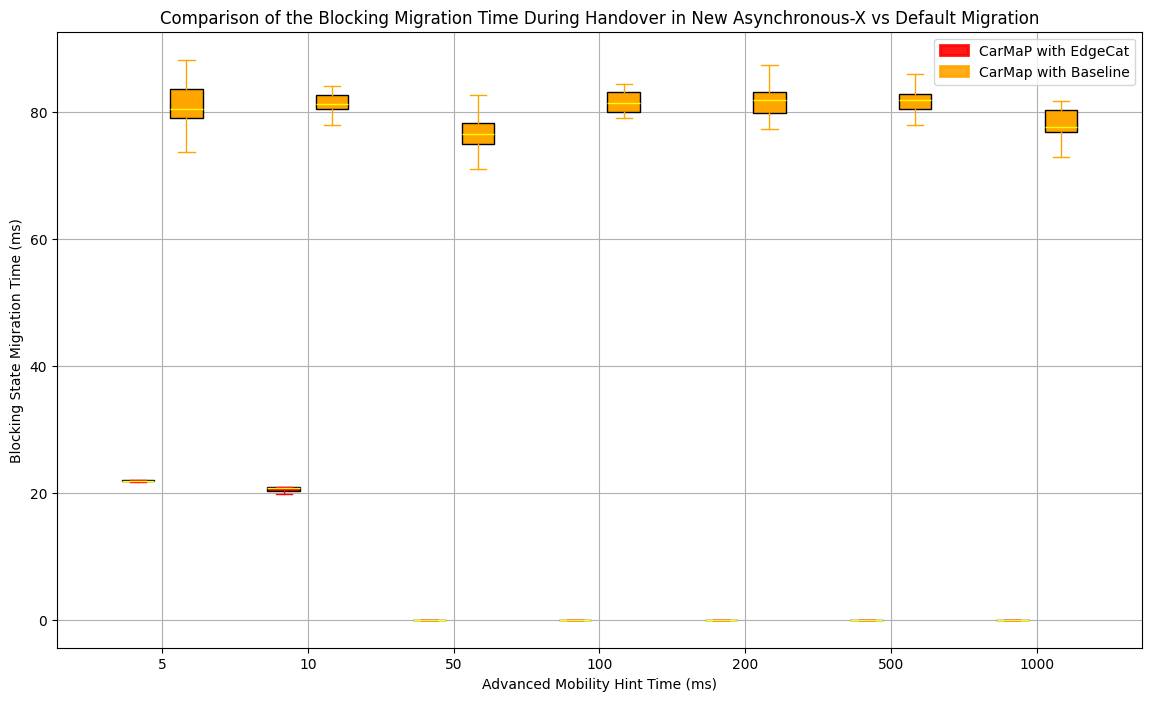

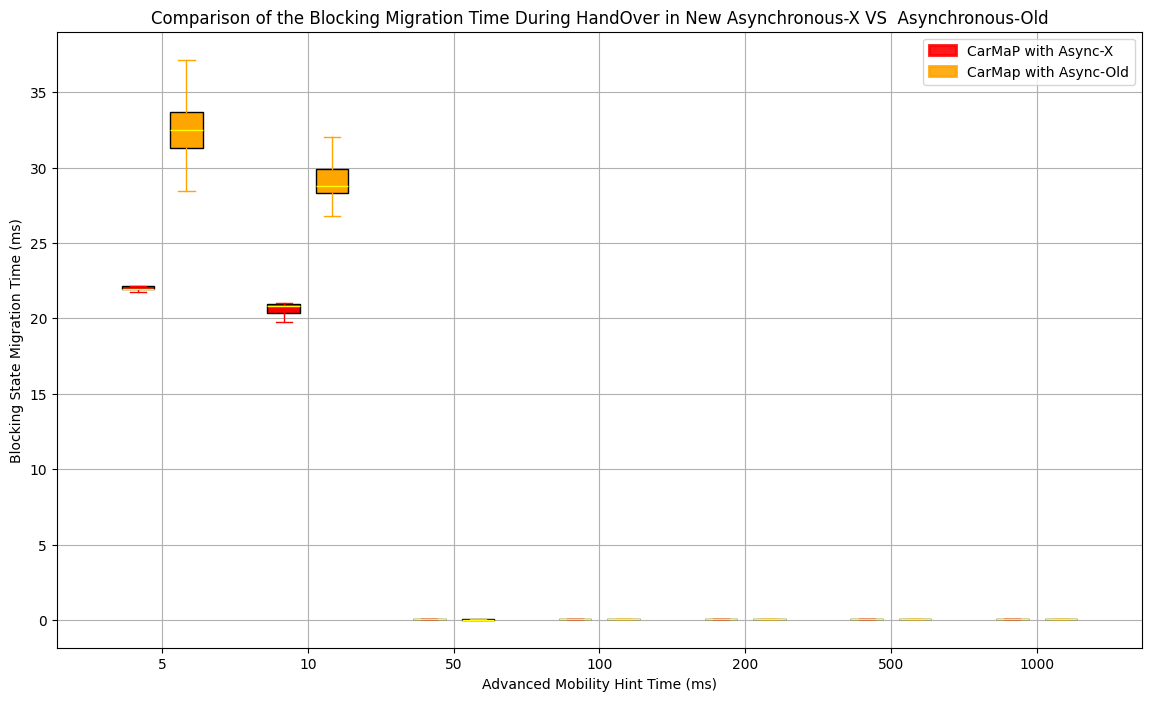

In [8]:

"""
    EXPERIMENT 1 : Find how was the Impact of early mobility hint on CarMap’s
blocking state migration time. In Sha Allah we will observe Improvements due to new Async Migration

"""

APPLICATION_NAME = "CarMAP_APP"
CAR_MAP_TOTAL_VARIABLES = [11]
CAR_MAP_DYNAMIC_VARIABLES = [2]
HANDOVERS = [10.005 , 10.010 , 10.050 , 10.1 , 10.2 , 10.5 ,11]
RESULT_DIR = f'results_fig_11_fig_12/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]
HANDOVER_XLABELS = [5 , 10 , 50 , 100 , 200 , 500 , 1000]


properties_Experiment_Fig_11 = {
    "dynamicVariables": CAR_MAP_DYNAMIC_VARIABLES[0],
    "totalVariables": CAR_MAP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}

defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []




for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    
    if(defaultMigration == 1) :

        properties_Experiment_Fig_11["asyncType"] = 0
        for handover in HANDOVERS :
            
            properties_Experiment_Fig_11["handoverTime"] = handover            
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_Fig_11)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_Fig_11["asyncType"] = asyncType
            if asyncType == 0:
                
                for handover in HANDOVERS :

                    properties_Experiment_Fig_11["handoverTime"] = handover
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])

                
            else :

                for handover in HANDOVERS :

                    properties_Experiment_Fig_11["handoverTime"] = handover
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", HANDOVER_XLABELS, "Advanced Mobility Hint Time (ms)" ,"Blocking State Migration Time (ms)", LEGEND_LABEL_CARMAP)

## 2) New Async Vs Old Async

plot_box_whisker_combined(newAsync_Results , oldAsync_Results , "Comparison of the Blocking Migration Time During HandOver in New Asynchronous-X VS  Asynchronous-Old", HANDOVER_XLABELS, "Advanced Mobility Hint Time (ms)" ,"Blocking State Migration Time (ms)", LEGEND_LABEL_CARMAP_2)






## REPLICATING THE FIGURE 12 RESULTS :

5 5 5


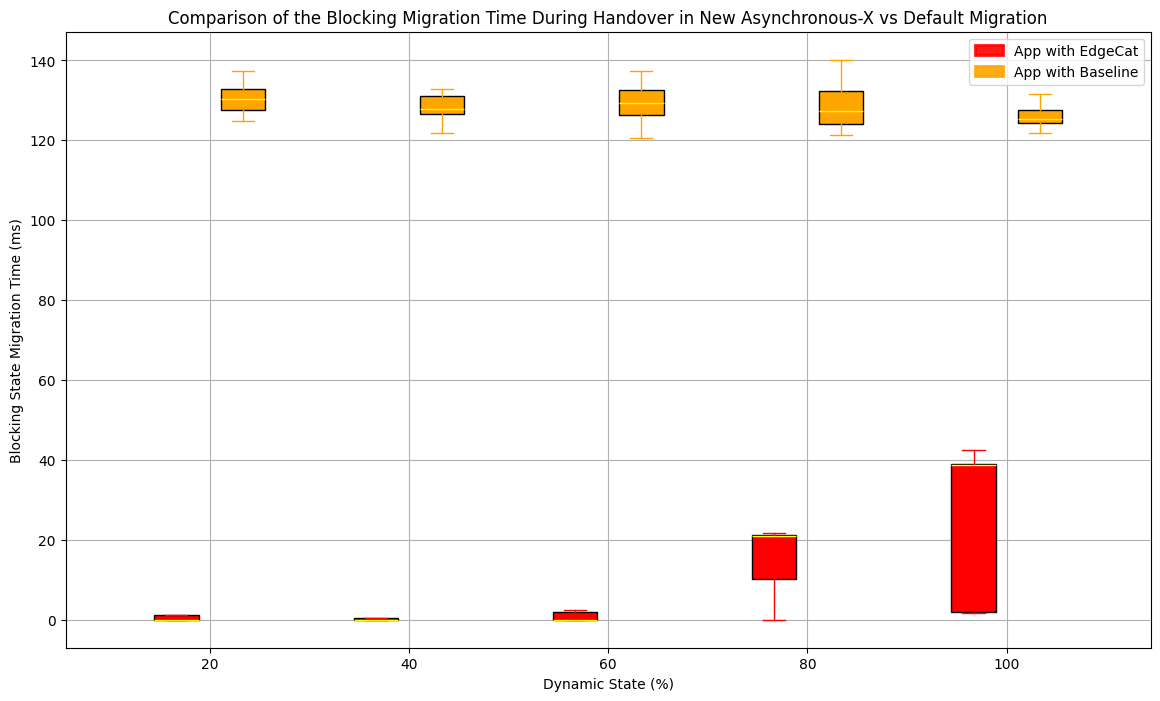

In [10]:


"""
    EXPERIMENT 2 : Find how was the EdgeCat’s application downtime with varying
    dynamic state size. The dynamic state update rate =
    50 updates/s.   In Sha Allah we will observe some more benefits here aswell  
"""



"""
    EXPERIMENT 1 : Find how was the Impact of early mobility hint on CarMap’s
blocking state migration time. In Sha Allah we will observe Improvements due to new Async Migration

"""

APPLICATION_NAME = "EdgeCAT_APP2"
EDGE_CAT2_TOTAL_VARIABLES = [10]
EDGE_CAT2_DYNAMIC_VARIABLES = [2 , 4 , 6 , 8 , 10]
RESULT_DIR = f'results_fig_11_fig_12/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]


properties_Experiment_Fig_11 = {
    "dynamicVariables": EDGE_CAT2_DYNAMIC_VARIABLES[0],
    "totalVariables": EDGE_CAT2_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 50,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}

defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []



for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    
    if(defaultMigration == 1) :

        properties_Experiment_Fig_11["asyncType"] = 0
        for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :
            
            properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable            
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_Fig_11)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_Fig_11["asyncType"] = asyncType
            if asyncType == 0:
                
                for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :

                    properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable    
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])

                
            else :

                for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :

                    properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable    
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))
# print(oldAsync_Results)
# print(newAsync_Results)

## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", DYNAMIC_STATE_X_LABEL, "Dynamic State (%)", "Blocking State Migration Time (ms)" , LEGEND_LABEL_APP)


## PRE_PROCESSING THE TABLE 4 & TABLE 5 Files :

In [11]:
# Specify the directory path
directory_path = 'results_tb_3_tb_4'


"""
    Step 1 : Adjusting the Header & Counters of the RTT Files :
"""
total_rtt_files = count_files(directory_path,"RTT")
print(f"Total number of RTT CSV files: {total_rtt_files}")
# Process RTT files
process_rtt_files(directory_path)
print(f"The RTT files have been successfully processed")



"""
    Step 2 : Adjusting the Header for the Event files :
"""
total_rtt_files = count_files(directory_path,"Events")
print(f"Total number of Events CSV files: {total_rtt_files}")
process_events_files(directory_path)
print(f"The Events files have been successfully processed")




Total number of RTT CSV files: 18
The RTT files have been successfully processed
Total number of Events CSV files: 18
The Events files have been successfully processed


## REPLICATING THE TABLE 4 RESULTS For The CARMAP :
- By silly mistake I named my directory `tb_3_tb4` where as it should have been `tb_4_tb5`
- if you see anything as `tb_3` , think it as of `table 4` related experiemnts , same goes for table 4 mentioned as tb_4.....

3 3 3


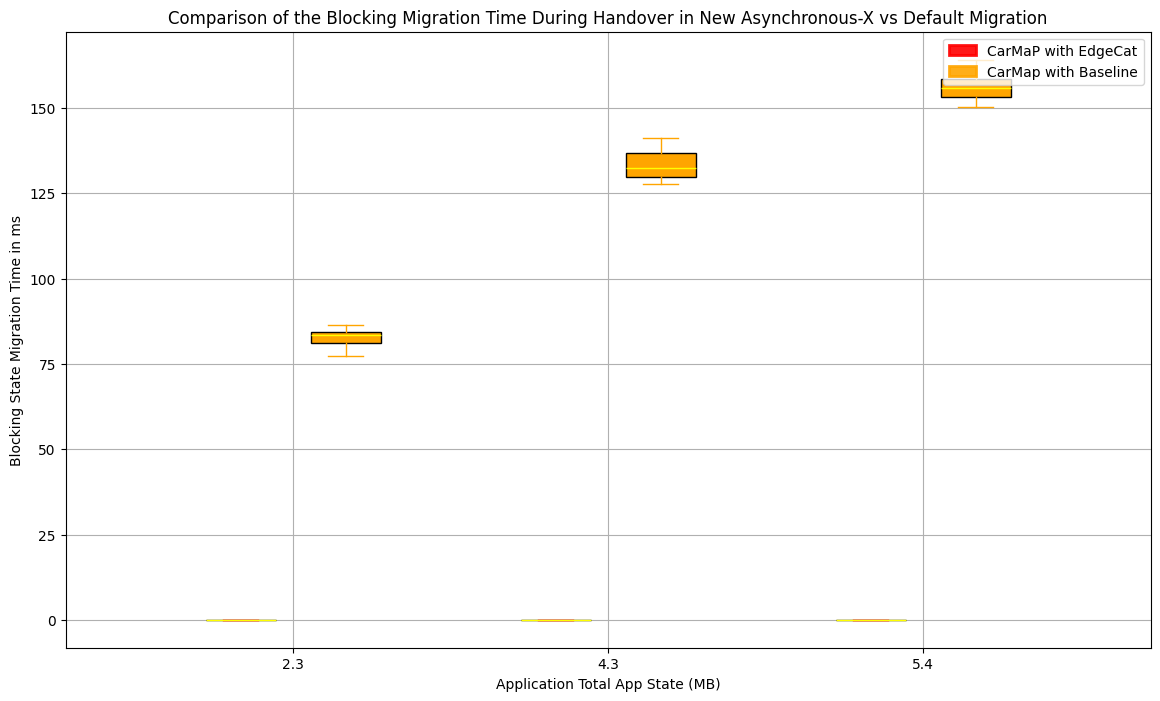

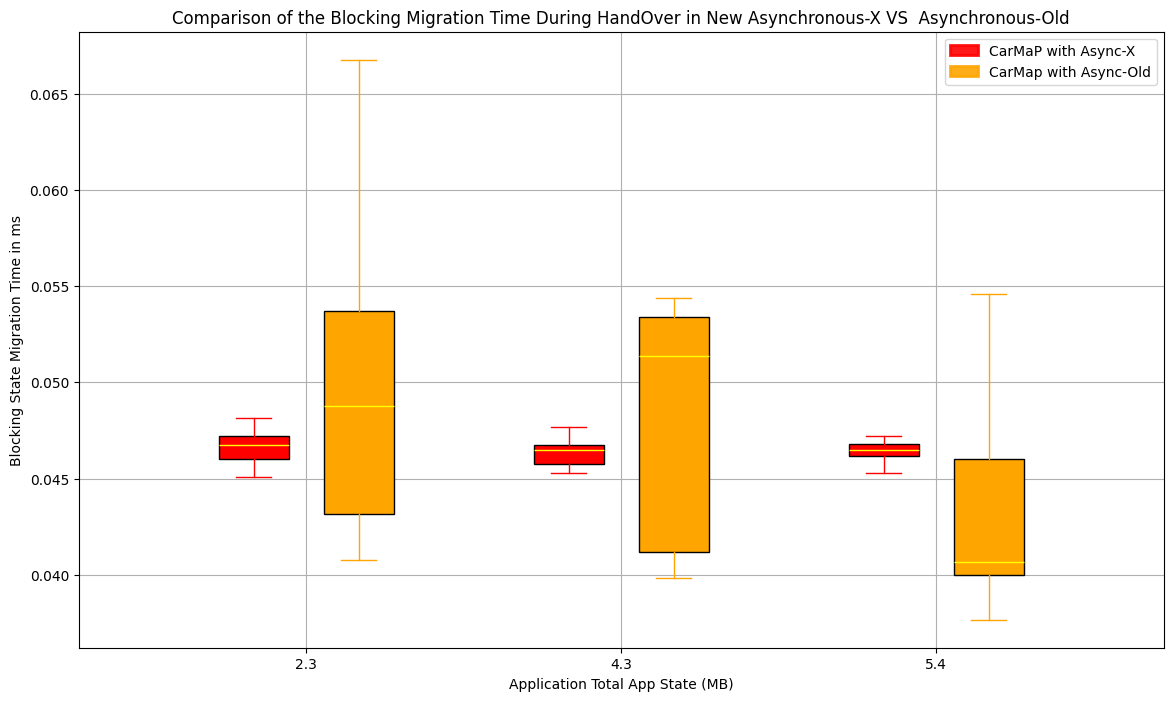

Means of the Async-x : [np.float64(0.22014379501342773), np.float64(0.04640817642211914), np.float64(0.5571365356445312)]
Means of the Async-old : [np.float64(0.33957958221435547), np.float64(0.3310680389404297), np.float64(0.042748451232910156)]
Means of the Default Migration : [np.float64(82.71527290344238), np.float64(133.41892957687378), np.float64(155.9949517250061)]


In [12]:

"""
    In this experiment we will observe the reduction in the blocking Migration Time of the CarMAP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration :
"""

APPLICATION_NAME = "CarMAP_APP"
CAR_MAP_TOTAL_VARIABLES = [11 , 6 , 10]
CAR_MAP_DYNAMIC_VARIABLES = [2 , 4 , 6]
RESULT_DIR = f'results_tb_3_tb_4/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_3 = {
    "dynamicVariables": CAR_MAP_DYNAMIC_VARIABLES[0],
    "totalVariables": CAR_MAP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []

newAsync_Means = []
oldAsync_Means = []
default_Means = []

index = 0

for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    index = 0
    if(defaultMigration == 1) :

        properties_Experiment_tb_3["asyncType"] = 0
        index = 0
        for total_variables in CAR_MAP_TOTAL_VARIABLES :
            
            properties_Experiment_tb_3["totalVariables"] = total_variables
            properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_tb_3)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats['mean'])
            index += 1


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_3["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                        oldAsync_Means.append(stats['mean'])
                    index += 1

                
            else :
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats['mean'])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", CARMAP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_CARMAP)

## 2) New Async Vs Old Async

plot_box_whisker_combined(newAsync_Results , oldAsync_Results , "Comparison of the Blocking Migration Time During HandOver in New Asynchronous-X VS  Asynchronous-Old",  CARMAP_STATE , "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_CARMAP_2)


print(f"Means of the Async-x : {newAsync_Means}")
print(f"Means of the Async-old : {oldAsync_Means}")
print(f"Means of the Default Migration : {default_Means}")


## REPLICATING THE TABLE 4 RESULTS For The EMP :

3 3 3


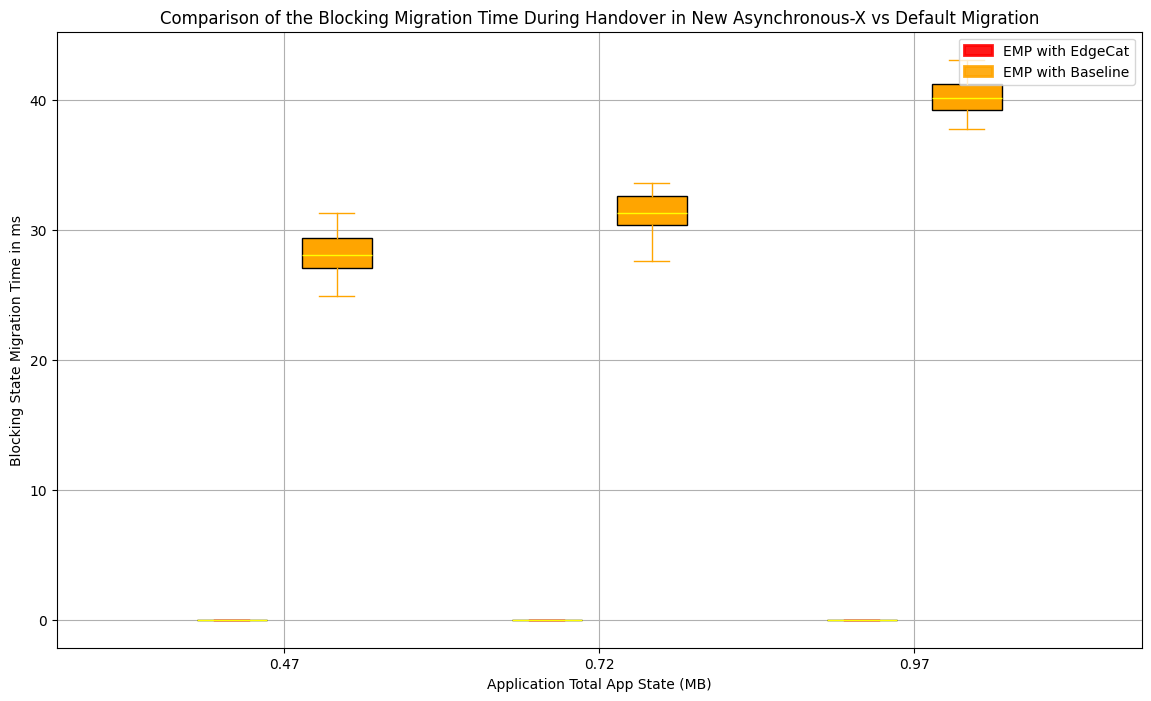

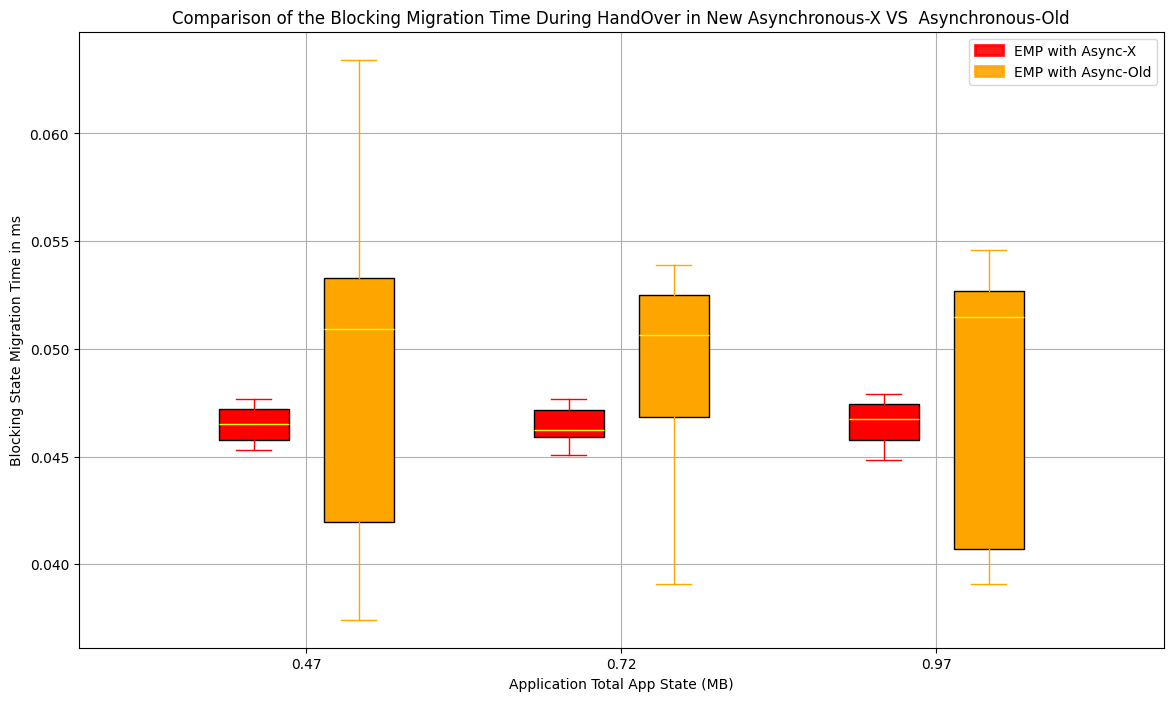

Means of the Async-x : [np.float64(0.04620552062988281), np.float64(0.37549734115600586), np.float64(1.0341644287109375)]
Means of the Async-old : [np.float64(0.04928112030029297), np.float64(0.979459285736084), np.float64(0.7275819778442383)]
Means of the Default Migration : [np.float64(27.95717716217041), np.float64(31.893491744995117), np.float64(40.37923812866211)]


In [13]:



"""
    In this experiment we will observe the reduction in the blocking Migration Time of the EMP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration :
"""

APPLICATION_NAME = "EMP_APP"
EMP_TOTAL_VARIABLES = [15 , 23 , 31]
RESULT_DIR = f'results_tb_3_tb_4/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_4 = {
    "dynamicVariables": EMP_TOTAL_VARIABLES[0],
    "totalVariables": EMP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []
newAsync_Means = []
oldAsync_Means = []
default_Means = []

for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    if(defaultMigration == 1) :

        properties_Experiment_tb_4["asyncType"] = 0
 
        for total_variables in EMP_TOTAL_VARIABLES  :
            
            properties_Experiment_tb_4["totalVariables"] = total_variables
            properties_Experiment_tb_4["dynamicVariables"] = total_variables
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_tb_4)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats["mean"])
           


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_4["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                        oldAsync_Means.append(stats["mean"])
                    index += 1

                
            else :
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats["mean"])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", EMP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_EMP)

## 2) New Async Vs Old Async

plot_box_whisker_combined(newAsync_Results , oldAsync_Results , "Comparison of the Blocking Migration Time During HandOver in New Asynchronous-X VS  Asynchronous-Old",  EMP_STATE , "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_EMP_2)


print(f"Means of the Async-x : {newAsync_Means}")
print(f"Means of the Async-old : {oldAsync_Means}")
print(f"Means of the Default Migration : {default_Means}")




## Now we will be replicating the Worst Case of these Applications with Async-X:

In [14]:
# Specify the directory path
directory_path = 'WorstCase/results/'


"""
    Step 1 : Adjusting the Header & Counters of the RTT Files :
"""
total_rtt_files = count_files(directory_path,"RTT")
print(f"Total number of RTT CSV files: {total_rtt_files}")
# Process RTT files
process_rtt_files(directory_path)
print(f"The RTT files have been successfully processed")



"""
    Step 2 : Adjusting the Header for the Event files :
"""
total_rtt_files = count_files(directory_path,"Events")
print(f"Total number of Events CSV files: {total_rtt_files}")
process_events_files(directory_path)
print(f"The Events files have been successfully processed")



Total number of RTT CSV files: 24
The RTT files have been successfully processed
Total number of Events CSV files: 24
The Events files have been successfully processed


3 3 3


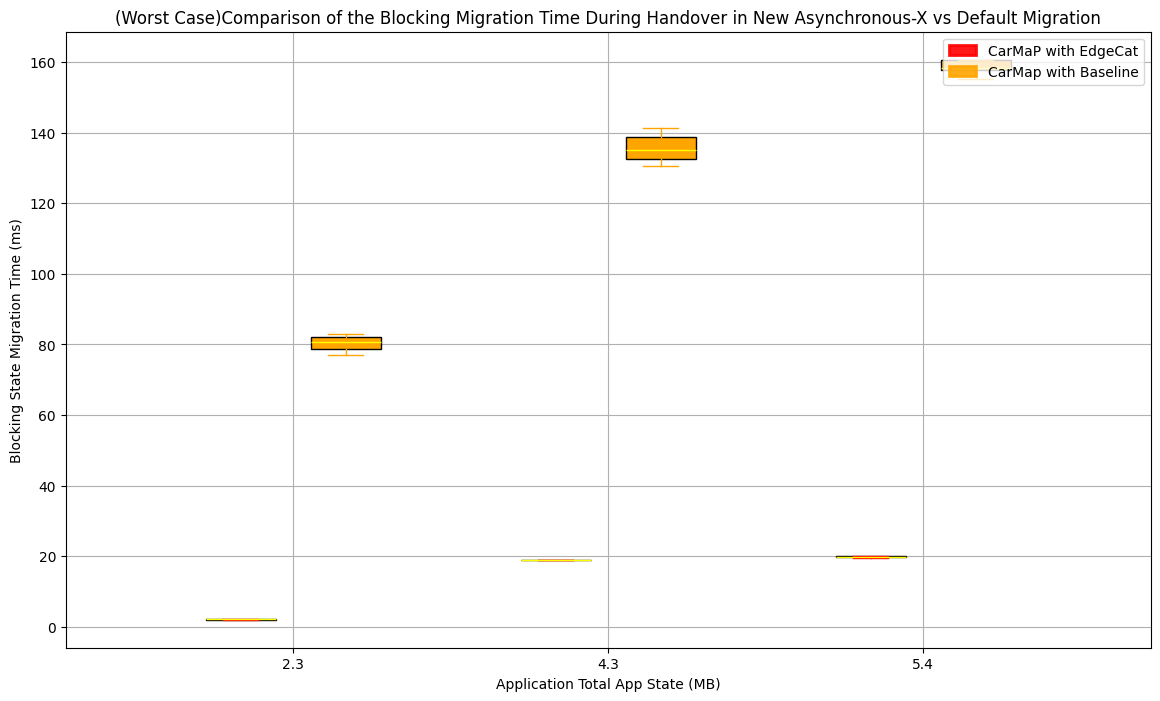

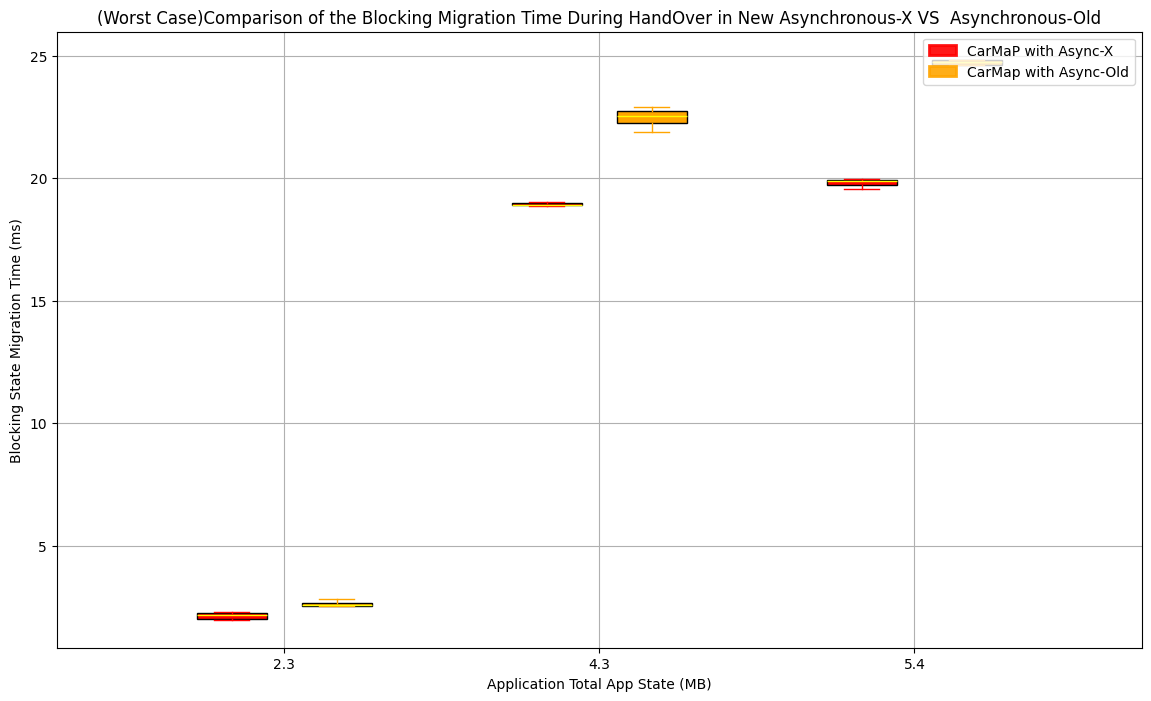

Means of the Async-x : [np.float64(2.271389961242676), np.float64(19.025087356567383), np.float64(19.949936866760254)]
Means of the Async-old : [np.float64(2.6327133178710938), np.float64(22.617125511169434), np.float64(24.986624717712402)]
Means of the Default Migration : [np.float64(80.31759262084961), np.float64(135.59842109680176), np.float64(159.3669891357422)]


In [15]:

"""
    In this experiment we will observe the reduction in the blocking Migration Time of the CarMAP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration :
"""

APPLICATION_NAME = "CarMAP_APP"
CAR_MAP_TOTAL_VARIABLES = [11 , 6 , 10]
CAR_MAP_DYNAMIC_VARIABLES = [2 , 4 , 6]
RESULT_DIR = f'WorstCase/results/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_3 = {
    "dynamicVariables": CAR_MAP_DYNAMIC_VARIABLES[0],
    "totalVariables": CAR_MAP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []

newAsync_Means = []
oldAsync_Means = []
default_Means = []

index = 0

for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    index = 0
    if(defaultMigration == 1) :

        properties_Experiment_tb_3["asyncType"] = 0
        index = 0
        for total_variables in CAR_MAP_TOTAL_VARIABLES :
            
            properties_Experiment_tb_3["totalVariables"] = total_variables
            properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_tb_3)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats['mean'])
            index += 1


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_3["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                        oldAsync_Means.append(stats['mean'])
                    index += 1

                
            else :
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats['mean'])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "(Worst Case)Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", CARMAP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time (ms)" , LEGEND_LABEL_CARMAP)

## 2) New Async Vs Old Async

plot_box_whisker_combined(newAsync_Results , oldAsync_Results , "(Worst Case)Comparison of the Blocking Migration Time During HandOver in New Asynchronous-X VS  Asynchronous-Old",  CARMAP_STATE , "Application Total App State (MB)" ,"Blocking State Migration Time (ms)" , LEGEND_LABEL_CARMAP_2)


print(f"Means of the Async-x : {newAsync_Means}")
print(f"Means of the Async-old : {oldAsync_Means}")
print(f"Means of the Default Migration : {default_Means}")


3 3 3


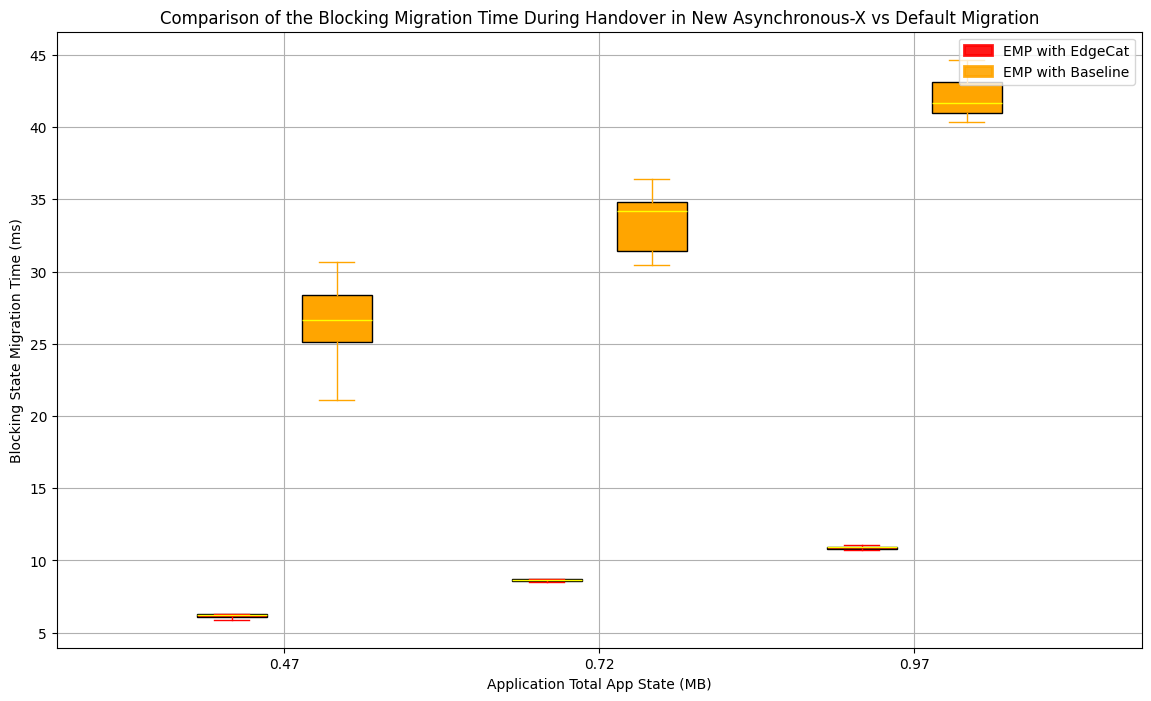

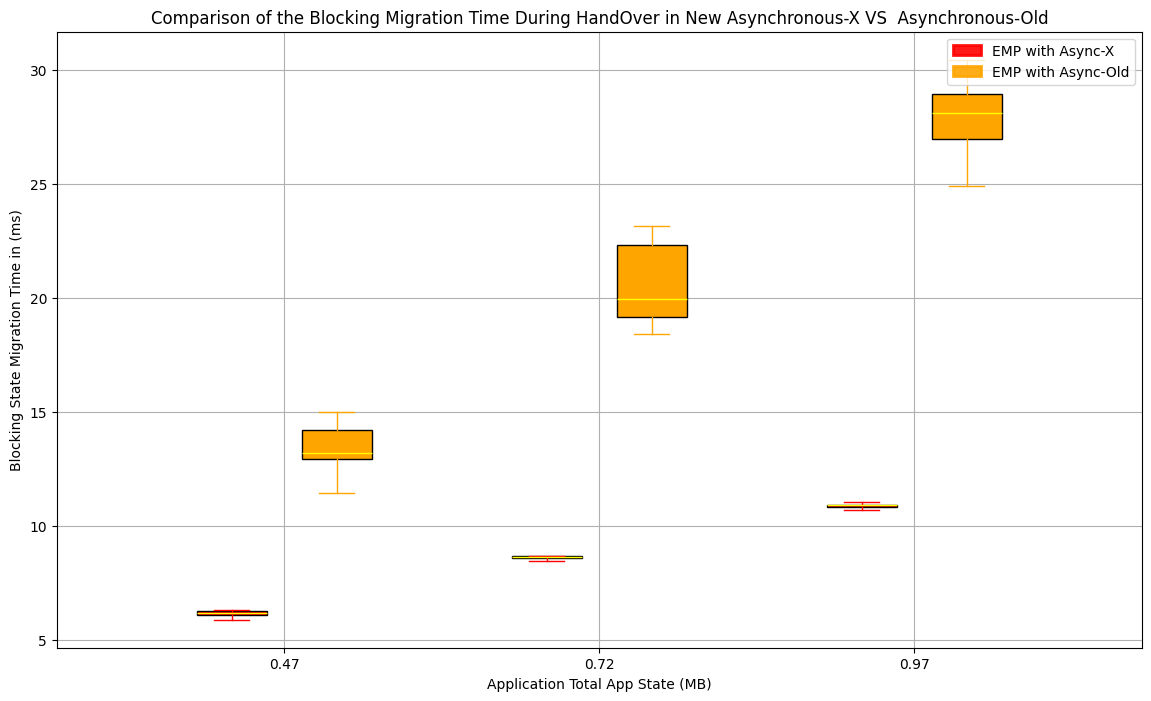

Means of the Async-x : [np.float64(6.407022476196289), np.float64(8.785367012023926), np.float64(10.906434059143066)]
Means of the Async-old : [np.float64(13.430476188659668), np.float64(20.571541786193848), np.float64(27.88217067718506)]
Means of the Default Migration : [np.float64(26.44519805908203), np.float64(33.53896141052246), np.float64(42.026448249816895)]


In [16]:



"""
    In this experiment we will observe the reduction in the blocking Migration Time of the EMP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration :
"""

APPLICATION_NAME = "EMP_APP"
EMP_TOTAL_VARIABLES = [15 , 23 , 31]
RESULT_DIR = f'WorstCase/results/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_4 = {
    "dynamicVariables": EMP_TOTAL_VARIABLES[0],
    "totalVariables": EMP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []
newAsync_Means = []
oldAsync_Means = []
default_Means = []

for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    if(defaultMigration == 1) :

        properties_Experiment_tb_4["asyncType"] = 0
 
        for total_variables in EMP_TOTAL_VARIABLES  :
            
            properties_Experiment_tb_4["totalVariables"] = total_variables
            properties_Experiment_tb_4["dynamicVariables"] = total_variables
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_tb_4)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats["mean"])
           


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_4["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-noredis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                        oldAsync_Means.append(stats["mean"])
                    index += 1

                
            else :
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats["mean"])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-X vs Default Migration", EMP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time (ms)" , LEGEND_LABEL_EMP)

## 2) New Async Vs Old Async

plot_box_whisker_combined(newAsync_Results , oldAsync_Results , "Comparison of the Blocking Migration Time During HandOver in New Asynchronous-X VS  Asynchronous-Old",  EMP_STATE , "Application Total App State (MB)" ,"Blocking State Migration Time in (ms)" , LEGEND_LABEL_EMP_2)


print(f"Means of the Async-x : {newAsync_Means}")
print(f"Means of the Async-old : {oldAsync_Means}")
print(f"Means of the Default Migration : {default_Means}")




## Async General Protcol table 4 & 5 Replication

## Pre-Processing the TABLE 4 & 5 Data 

In [182]:


# Specify the directory path
directory_path = 'results_async_normal_tb_4_tb_5'


"""
    Step 1 : Adjusting the Header & Counters of the RTT Files :
"""
total_rtt_files = count_files(directory_path,"RTT")
print(f"Total number of RTT CSV files: {total_rtt_files}")
# Process RTT files
process_rtt_files(directory_path)
print(f"The RTT files have been successfully processed")



"""
    Step 2 : Adjusting the Header for the Event files :
"""
total_rtt_files = count_files(directory_path,"Events")
print(f"Total number of Events CSV files: {total_rtt_files}")
process_events_files(directory_path)
print(f"The Events files have been successfully processed")




Total number of RTT CSV files: 12
The RTT files have been successfully processed
Total number of Events CSV files: 12
The Events files have been successfully processed


0 3 3


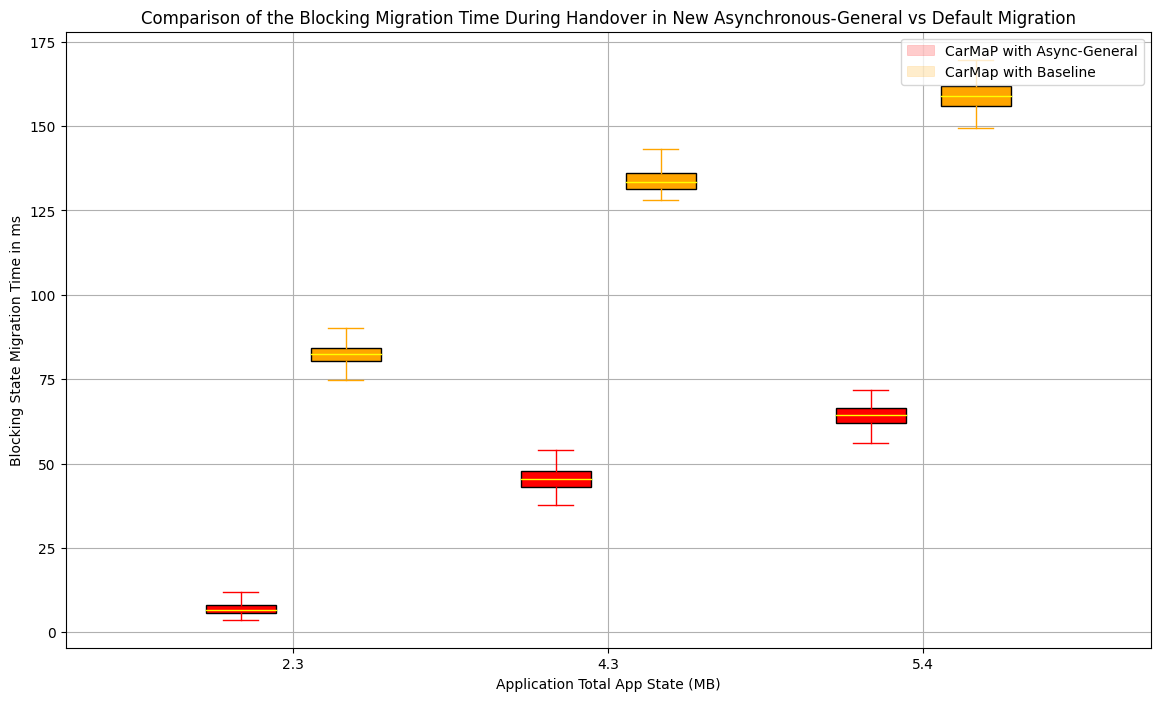

Means of the default : [82.44102751767194, 134.24691614115014, 158.90953225909539]
Means of the Async General : [6.855462111678778, 45.53784238229884, 62.83195892182907]


In [184]:



"""
    In this experiment we will observe the reduction in the blocking Migration Time of the CarMAP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration (GENERAL VERSION):
"""

APPLICATION_NAME = "CarMAP_APP"
CAR_MAP_TOTAL_VARIABLES = [11 , 6 , 10]
CAR_MAP_DYNAMIC_VARIABLES = [2 , 4 , 6]
RESULT_DIR = f'results_async_normal_tb_4_tb_5/{APPLICATION_NAME}'
OLDRESULT_DIR = f'results_async_normal_tb_4_tb_5/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_3 = {
    "dynamicVariables": CAR_MAP_DYNAMIC_VARIABLES[0],
    "totalVariables": CAR_MAP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []

newAsync_Means = []
default_Means = []

index = 0

for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    index = 0
    if(defaultMigration == 1) :

        properties_Experiment_tb_3["asyncType"] = 1
        index = 0
        for total_variables in CAR_MAP_TOTAL_VARIABLES :
            
            properties_Experiment_tb_3["totalVariables"] = total_variables
            properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
            matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/default", properties_Experiment_tb_3)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats['mean'])
            index += 1


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_3["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/async-modified-noredis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                    index += 1

                
            else :
                index = 0
                for total_variables in CAR_MAP_TOTAL_VARIABLES :

                    properties_Experiment_tb_3["totalVariables"] = total_variables
                    properties_Experiment_tb_3["dynamicVariables"] = CAR_MAP_DYNAMIC_VARIABLES[index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_3)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats['mean'])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))


## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-General vs Default Migration", CARMAP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_CARMAP_GENERAL)

print(f"Means of the default : {default_Means}")
print(f"Means of the Async General : {newAsync_Means}")





## REPLICATING THE TABLE 5 RESULTS For The EMP :

0 3 3


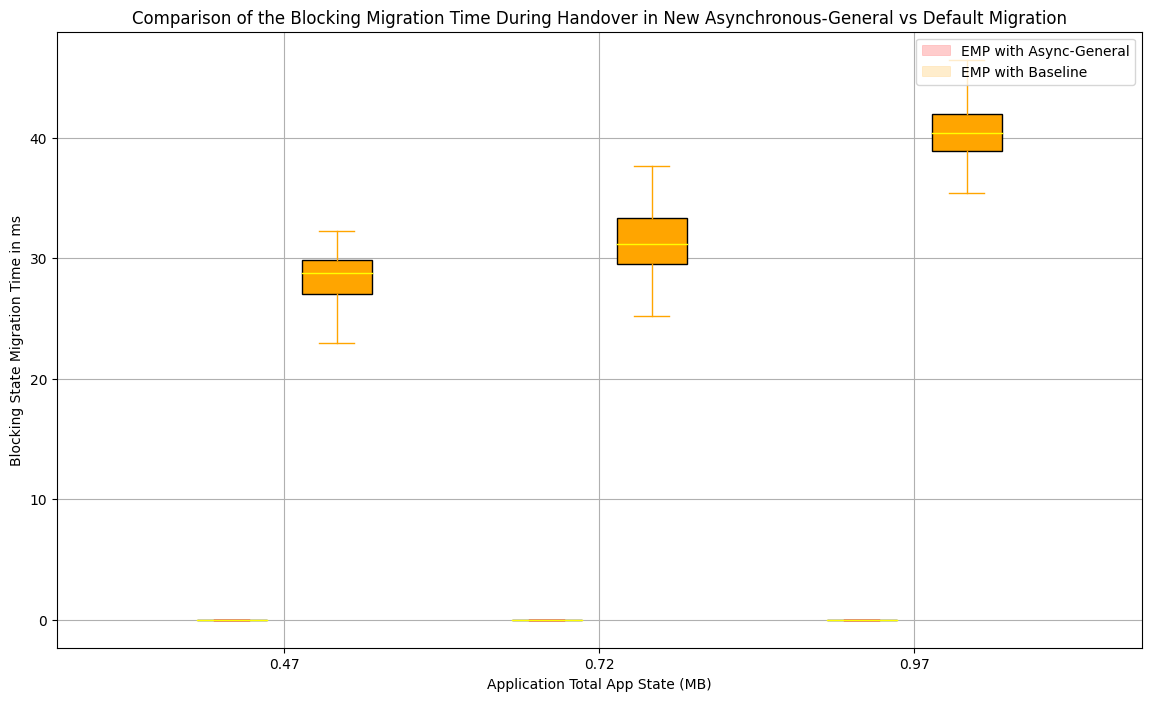

[1.3092947006225586, 1.2467098236083984, 2.819821834564209]
[28.18951239952674, 31.346885903367717, 40.50792073740543]


In [186]:


"""
    In this experiment we will observe the reduction in the blocking Migration Time of the EMP In Sha Allah due to preimptive state migration
    and the inbuilt redis Async Migration (GENERAL VERSION):
"""

APPLICATION_NAME = "EMP_APP"
EMP_TOTAL_VARIABLES = [15 , 23 , 31]
RESULT_DIR = f'results_async_normal_tb_4_tb_5/{APPLICATION_NAME}'
OLDRESULT_DIR = f'results_async_normal_tb_4_tb_5/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]

properties_Experiment_tb_4 = {
    "dynamicVariables": EMP_TOTAL_VARIABLES[0],
    "totalVariables": EMP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}


defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []
newAsync_Means = []
default_Means = []


for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    if(defaultMigration == 1) :

        properties_Experiment_tb_4["asyncType"] = 1
 
        for total_variables in EMP_TOTAL_VARIABLES  :
            
            properties_Experiment_tb_4["totalVariables"] = total_variables
            properties_Experiment_tb_4["dynamicVariables"] = total_variables
            matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/default", properties_Experiment_tb_4)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])
                default_Means.append(stats["mean"])
           


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_tb_4["asyncType"] = asyncType
            if asyncType == 0:
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/async-modified-noredis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])
                    index += 1

                
            else :
                index = 0
                for total_variables in EMP_TOTAL_VARIABLES  :

                    properties_Experiment_tb_4["totalVariables"] = total_variables
                    properties_Experiment_tb_4["dynamicVariables"] = EMP_TOTAL_VARIABLES [index]
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_tb_4)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
                        newAsync_Means.append(stats["mean"])
                    index += 1
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))



## Plotting the Graphs : 

## 1) Default Vs New Async

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-General vs Default Migration", EMP_STATE, "Application Total App State (MB)" ,"Blocking State Migration Time in ms" , LEGEND_LABEL_EMP_GENERAL)

print(newAsync_Means)
print(default_Means)



## REPLICATING THE FIGURE 11 RESULTS :

## Preprocessing the Async General Redis Figure 11 Results

In [187]:
# Specify the directory path
directory_path = 'results_async_normal_fig_11_fig_12'


"""
    Step 1 : Adjusting the Header & Counters of the RTT Files :
"""
total_rtt_files = count_files(directory_path,"RTT")
print(f"Total number of RTT CSV files: {total_rtt_files}")
# Process RTT files
process_rtt_files(directory_path)
print(f"The RTT files have been successfully processed")



"""
    Step 2 : Adjusting the Header for the Event files :
"""
total_rtt_files = count_files(directory_path,"Events")
print(f"Total number of Events CSV files: {total_rtt_files}")
process_events_files(directory_path)
print(f"The Events files have been successfully processed")



Total number of RTT CSV files: 0
The RTT files have been successfully processed
Total number of Events CSV files: 31
The Events files have been successfully processed


## Creating the Async General Redis Figure 11 Results

0 7 7


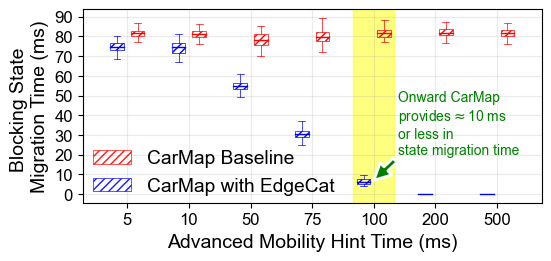

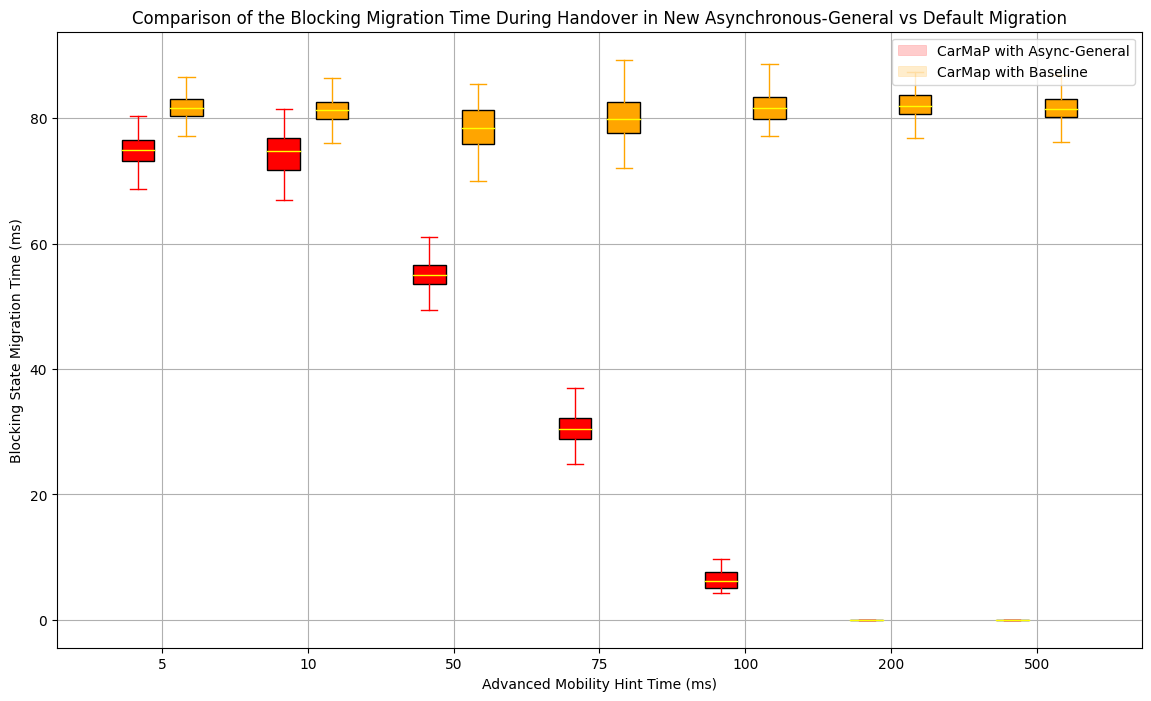

In [202]:



"""
    EXPERIMENT 1 : Find how was the Impact of early mobility hint on CarMap’s
blocking state migration time. In Sha Allah we will observe Improvements due to new Async Migration

"""

APPLICATION_NAME = "CarMAP_APP"
CAR_MAP_TOTAL_VARIABLES = [11]
CAR_MAP_DYNAMIC_VARIABLES = [2]
HANDOVERS = [10.005 , 10.010 , 10.050 , 10.075 , 10.1 , 10.2 , 10.5]
RESULT_DIR = f'results_async_normal_fig_11_fig_12/{APPLICATION_NAME}'
OLDRESULT_DIR = f'results_async_normal_fig_11_fig_12/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]


properties_Experiment_Fig_11 = {
    "dynamicVariables": CAR_MAP_DYNAMIC_VARIABLES[0],
    "totalVariables": CAR_MAP_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 1,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}

defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []



for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    
    if(defaultMigration == 1) :

        properties_Experiment_Fig_11["asyncType"] = 1
        for handover in HANDOVERS :
            
            properties_Experiment_Fig_11["handoverTime"] = handover            
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_Fig_11)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_Fig_11["asyncType"] = asyncType
            if asyncType == 0:
                
                for handover in HANDOVERS :

                    properties_Experiment_Fig_11["handoverTime"] = handover
                    matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/async-modified-noredis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])

                
            else :

                for handover in HANDOVERS :

                    properties_Experiment_Fig_11["handoverTime"] = handover
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))
# print(oldAsync_Results)
# print(newAsync_Results)

## Plotting the Graphs : 

## 1) Default Vs New Async


plot_box_whisker_combined_2(newAsync_Results , defaultMigration_Results , "", ADVANCE_HINT, "Advanced Mobility Hint Time (ms)" ,"Blocking State \nMigration Time (ms)",  LEGEND_PAPER_FIG_11, True , False , (0.006,0,0.1,0.1) , "lower left","graphs/figure_11.png")

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-General vs Default Migration", ADVANCE_HINT, "Advanced Mobility Hint Time (ms)" ,"Blocking State Migration Time (ms)", LEGEND_LABEL_CARMAP_GENERAL)



## Creating the Async General (Normal) Redis Figure 12 Results

0 5 5


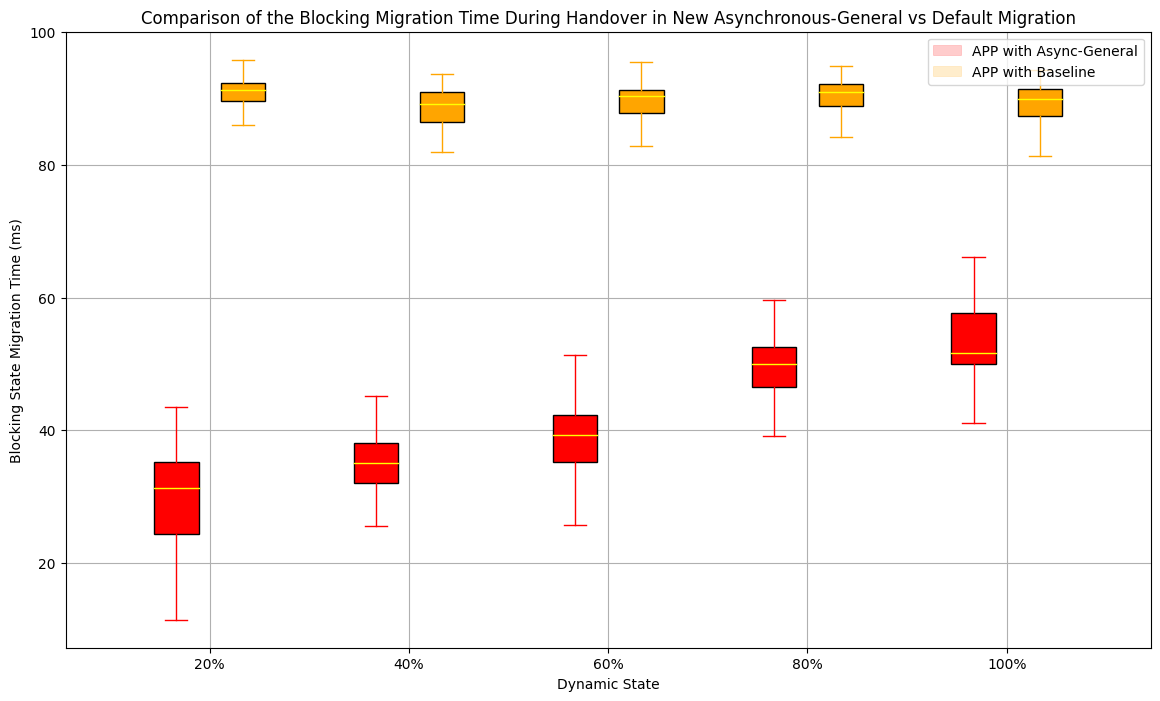

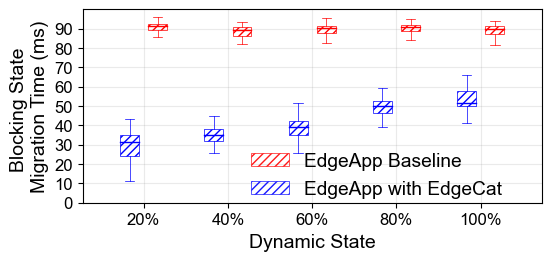

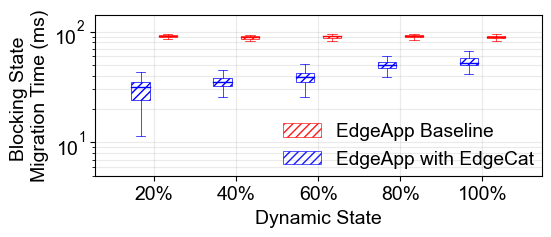

In [205]:





"""
    EXPERIMENT 2 : Find how was the EdgeCat’s application downtime with varying
    dynamic state size. The dynamic state update rate =
    50 updates/s.   In Sha Allah we will observe some more benefits here aswell  
"""



"""
    EXPERIMENT 1 : Find how was the Impact of early mobility hint on CarMap’s
blocking state migration time. In Sha Allah we will observe Improvements due to new Async Migration

"""

APPLICATION_NAME = "EdgeCAT_APP"
EDGE_CAT2_TOTAL_VARIABLES = [5]
EDGE_CAT2_DYNAMIC_VARIABLES = [1 , 2 , 3 , 4 , 5]
RESULT_DIR = f'results_async_normal_fig_11_fig_12/{APPLICATION_NAME}'
OLDRESULT_DIR = f'results_async_normal_fig_11_fig_12/{APPLICATION_NAME}'
ASYNC_TYPE = [0,1]
DEFAULTMIGRATION = [0,1]


properties_Experiment_Fig_11 = {
    "dynamicVariables": EDGE_CAT2_DYNAMIC_VARIABLES[0],
    "totalVariables": EDGE_CAT2_TOTAL_VARIABLES[0],
    "asyncType": 0,
    "hintTime": 10,
    "handoverTime": 10.1,
    "clientRequestRate": 50,
    "minOldestUpdates": 1,
    "maxOldestUpdates": 1,
    "fileType" : "Events"
}

defaultMigration_Results = []
oldAsync_Results = []
newAsync_Results = []



for defaultMigration in DEFAULTMIGRATION :


    # properties_Experiment_Fig_11["isDefaultMigrationEnabled"] = defaultMigration
    
    if(defaultMigration == 1) :

        properties_Experiment_Fig_11["asyncType"] = 1
        for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :
            
            properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable            
            matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/default", properties_Experiment_Fig_11)
            for matchingFile in matchingFiles :
                stats = calculate_handover_MigrationTime_statistics(matchingFile)
                defaultMigration_Results.append(stats['Migration_Time'])


    else :

        for asyncType in ASYNC_TYPE :

            properties_Experiment_Fig_11["asyncType"] = asyncType
            if asyncType == 0:
                
                for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :

                    properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable    
                    matchingFiles = get_filenames_by_properties(f"{OLDRESULT_DIR}/async-modified-noredis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        oldAsync_Results.append(stats['Migration_Time'])

                
            else :

                for dynamicVariable in EDGE_CAT2_DYNAMIC_VARIABLES :

                    properties_Experiment_Fig_11["dynamicVariables"] = dynamicVariable    
                    matchingFiles = get_filenames_by_properties(f"{RESULT_DIR}/async-modified-redis", properties_Experiment_Fig_11)
                    for matchingFile in matchingFiles :
                        stats = calculate_handover_MigrationTime_statistics(matchingFile)
                        newAsync_Results.append(stats['Migration_Time'])
            


print(len(oldAsync_Results) , len(newAsync_Results) , len(defaultMigration_Results))

## Plotting the Graphs : 

## 1) Default Vs New Async General

plot_box_whisker_combined(newAsync_Results , defaultMigration_Results , "Comparison of the Blocking Migration Time During Handover in New Asynchronous-General vs Default Migration", DYNAMIC_STATE_X_LABEL, "Dynamic State", "Blocking State Migration Time (ms)" , LEGEND_LABEL_APP_GENERAL)

plot_box_whisker_combined_2(newAsync_Results , defaultMigration_Results , "", DYNAMIC_STATE_X_LABEL, "Dynamic State", "Blocking State \nMigration Time (ms)" , LEGEND_PAPER_FIG_12, False , False , (0.35,-0.015,0,0.0) , "lower left", "graphs/figure_12.png")

plot_box_whisker_combined_2(newAsync_Results , defaultMigration_Results , "", DYNAMIC_STATE_X_LABEL, "Dynamic State", "Blocking State \nMigration Time (ms)" , LEGEND_PAPER_FIG_12, False ,True , None , "lower right", "graphs/figure_12_log_scale.png")



